In [1]:
import matplotlib.pyplot as plt


def plot_function(fn, space, fig=None, ax=None, scatter_markers=None, output_index=-1):
    # fn: function to plot
    # output_index: -1 if the output of the function is a single value; if the outputs are tuples index of the output that should be plotted
    res = fn(space)
    if output_index >= 0:
        res = res[output_index]
    res = res.to("cpu").detach()
    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows=1)
    # ax.matshow(res)
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py
    cntr = ax.contourf(
        xi,
        yi,
        res.reshape(int(len(res) ** (1 / 2)), int(len(res) ** (1 / 2))),
        levels=50,
    )
    fig.colorbar(cntr, ax=ax)
    if scatter_markers is not None:
        scatter_markers = scatter_markers
        ax.scatter(
            x=scatter_markers[:, 1], y=scatter_markers[:, 0], c="red", marker="x"
        )
    return fig, ax

# Test Hydra Config

In [1]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")

In [7]:

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config = compose(config_name="main.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config)

dataset = hydra.utils.instantiate(
    config.dataset,
    float_precision=config.float_precision,
)

oracle = hydra.utils.instantiate(
    config.oracle,
    device=config.device,
    float_precision=config.float_precision,
)

filter = hydra.utils.instantiate(
    config.filter,
    oracle=oracle,
)

surrogate = hydra.utils.instantiate(
    config.surrogate,
    device=config.device,
    float_precision=config.float_precision,
    maximize=config.maximize,
)

sampler = hydra.utils.instantiate(
    config.sampler,
    surrogate=surrogate,
)
sampler

{'device': 'cuda', 'float_precision': 64, 'budget': 5, 'n_samples': 3, 'seed': 31415, 'maximize': False, 'dataset': {'_target_': 'dataset.dataset.BraninDatasetHandler', 'grid_size': 10, 'normalize_scores': True, 'train_fraction': 1.0, 'batch_size': 16, 'shuffle': True, 'train_path': 'storage/branin/data_10_train.csv', 'test_path': None}, 'oracle': {'_target_': 'gflownet.proxy.box.branin.Branin', 'fidelity': '1,', 'do_domain_map': True}, 'filter': {'_target_': 'filter.filter.Filter'}, 'logger': {'_target_': 'utils.logger.Logger', 'do': {'online': True, 'times': True}, 'project_name': 'MF-AL-GFN', 'train': {'period': 1}, 'test': {'first_it': True, 'period': 100, 'n': 100, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}, 'n_top_k': 5000, 'top_k': 100, 'top_k_period': -1, 'n_trajs_logprobs': 10, 'logprobs_batch_size': 100, 'logprobs_bootstrap_size': 10000, 'max_data_logprobs': 100000.0}, 'oracle': {'period': 100000, 'k': [1, 10, 100]}, 'context': '0', 'notes': None, 'ckpts': {'policy': {'p

# Active Learning Loop

In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np

n_iterations = 10  # TODO: replace with budget
grid_size = 10

from gflownet.utils.common import set_float_precision
float_prec = set_float_precision(64)
# float_prec = torch.double
n_samples = 3
maximize = False

# define candidate set
xi = np.arange(0, grid_size)
yi = np.arange(0, grid_size)
grid = np.array(np.meshgrid(xi, yi))
grid_flat = torch.tensor(grid.T, dtype=float_prec).reshape(-1, 2)
from dataset.dataset import Branin_Data

candidate_set, _ = Branin_Data(grid_size, grid_flat)[:]
xi = xi / grid_size
yi = yi / grid_size

import matplotlib.colors as cm

# colors = ["red", "blue", "green", "orange", "brown", "pink"]
colors = plt.get_cmap("Reds")

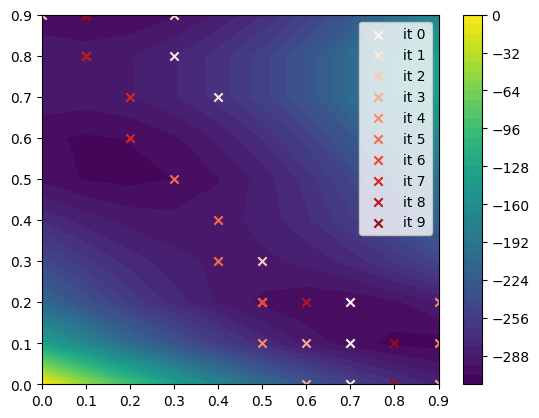

Text(0.5, 1.0, 'Best Score in each iteration')

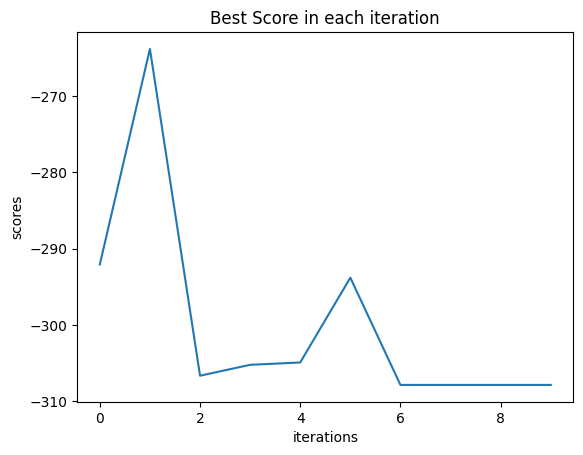

In [3]:
from dataset.dataset import BraninDatasetHandler
from surrogate.surrogate import SingleTaskGPRegressor
from sampler.sampler import GreedySampler, RandomSampler
from filter.filter import Filter, OracleFilter
from gflownet.proxy.box.branin import Branin


# Dataset
dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)
# Oracle
oracle = Branin(
    fidelity=1, do_domain_map=True, device=device, float_precision=float_prec
)
# Filter
filter = Filter()
# filter = OracleFilter(oracle)

if plot_function is not None:
    fig, ax = plot_function(oracle, candidate_set.clone().to(device))

best_scores = []

for i in range(n_iterations):

    train_data, test_data = dataset_handler.get_dataloader()
    # print("iteration", i)
    # Surrogate (e.g., Bayesian Optimization)
    # starts with a clean slate each iteration
    surrogate = SingleTaskGPRegressor(
        float_precision=float_prec, device=device, maximize=maximize
    )
    surrogate.fit(train_data)

    # Sampler (e.g., GFlowNet, or Random Sampler)
    # also starts with a clean slate; TODO: experiment with NOT training from scratch
    # sampler = RandomSampler(surrogate)
    sampler = GreedySampler(surrogate)
    sampler.fit()  # only necessary for samplers that train a model

    samples = sampler.get_samples(
        n_samples * 3, candidate_set=candidate_set.clone().to(device)
    )
    filtered_samples = filter(
        n_samples=n_samples, candidate_set=samples.clone(), maximize=maximize
    )

    if ax is not None:
        ax.scatter(
            x=filtered_samples[:, 0].cpu(),
            y=filtered_samples[:, 1].cpu(),
            c=cm.to_hex(colors(i / n_iterations)),
            marker="x",
            label="it %i" % i,
        )

    scores = oracle(filtered_samples.clone())
    dataset_handler.update_dataset(filtered_samples.cpu(), scores.cpu())
    best_scores.append(scores.min().cpu())

plt.legend()
plt.show()

plt.plot(best_scores)
plt.xlabel("iterations")
plt.ylabel("scores")
plt.title("Best Score in each iteration")

# Test individual components

In [2]:
import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)


from gflownet.utils.common import set_float_precision
float_prec = set_float_precision(64)
# float_prec = torch.double

import numpy as np
grid_size = 10  # 100
test_states = torch.tensor([[0.5, 0.5]])
test_scores = torch.tensor([-150.0])
n_samples = 5

baseline_states = torch.tensor(
    [
        [0.0 * grid_size, 0.0 * grid_size],
        [0.0 * grid_size, 0.4 * grid_size],
        [0.4 * grid_size, 0.0 * grid_size],
        [0.8 * grid_size, 0.8 * grid_size],
    ]
)

# define grid space
xi = np.arange(0, 1, 1 / grid_size)
yi = np.arange(0, 1, 1 / grid_size)
grid = np.array(np.meshgrid(xi, yi))
grid_flat = torch.tensor(grid.T, dtype=float_prec).reshape(-1, 2).to(device)

cuda


In [3]:
# dataset
from dataset.dataset import BraninDatasetHandler

dataset_handler = BraninDatasetHandler(
    grid_size=grid_size,
    train_path="./storage/branin/data_%i_train.csv" % grid_size,
    train_fraction=1.0,
    float_precision=float_prec,
)

# testing dataset
dataset_handler.update_dataset(test_states, test_scores)
print(dataset_handler.train_data.X_data, dataset_handler.train_data.y_data)
print(dataset_handler.train_data[:])
train_loader, test_loader = dataset_handler.get_dataloader()
for X, y in train_loader:
    print(X, y)

tensor([[0., 0.],
        [0., 4.],
        [4., 0.],
        [8., 8.],
        [5., 5.]], dtype=torch.float64) tensor([  -0.8709, -171.1192, -273.2218, -174.8874, -150.0000],
       dtype=torch.float64)
(tensor([[0.0000, 0.0000],
        [0.0000, 0.4000],
        [0.4000, 0.0000],
        [0.8000, 0.8000],
        [0.5000, 0.5000]], dtype=torch.float64), tensor([1.0000, 0.3749, 0.0000, 0.3611, 0.4524], dtype=torch.float64))
tensor([[0.0000, 0.4000],
        [0.5000, 0.5000],
        [0.8000, 0.8000],
        [0.0000, 0.0000],
        [0.4000, 0.0000]], dtype=torch.float64) tensor([0.3749, 0.4524, 0.3611, 1.0000, 0.0000], dtype=torch.float64)


tensor([  -0.8709, -171.1192, -273.2218, -174.8874], device='cuda:0',
       dtype=torch.float64)


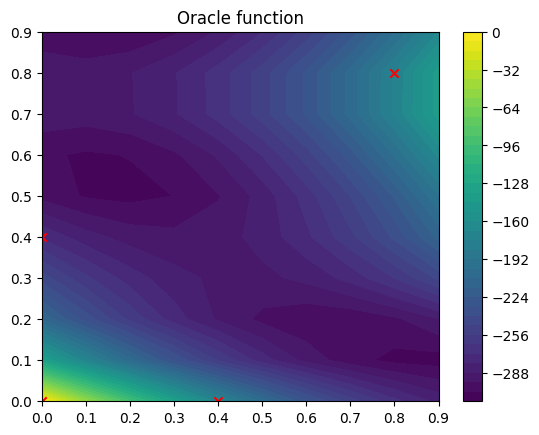

In [4]:
# Oracle
from gflownet.proxy.box.branin import Branin

oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=float_prec)

# testing oracle
print(oracle(baseline_states.to(device).clone() / grid_size))

# plot oracle function
plot_function(oracle, grid_flat.clone(), scatter_markers=baseline_states / grid_size)
plt.title("Oracle function")
plt.show()

tensor([-0.4285], device='cuda:0', dtype=torch.float64) tensor([0.1735], device='cuda:0', dtype=torch.float64)


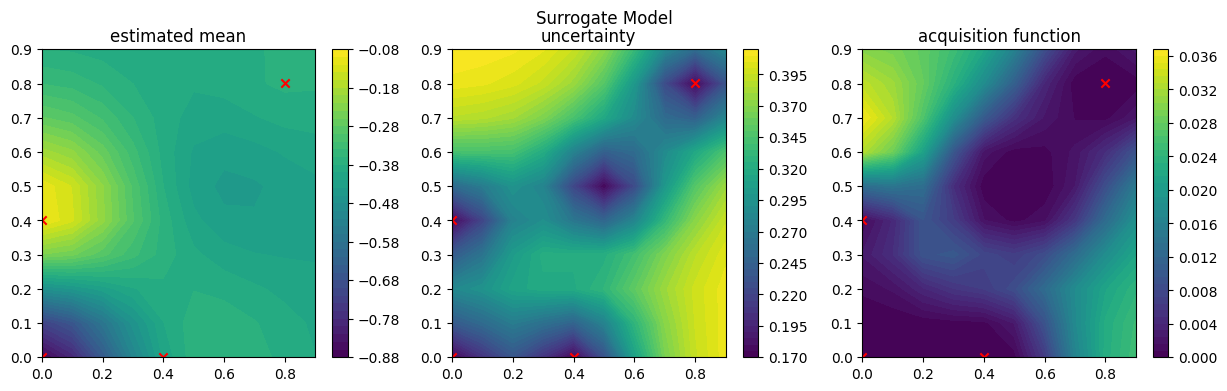

In [5]:
# Surrogate (e.g., Bayesian Optimization)
from surrogate.surrogate import SingleTaskGPRegressor

surrogate = SingleTaskGPRegressor(device=device, float_precision=float_prec, maximize=False)
train_data, test_data = dataset_handler.get_dataloader()
surrogate.fit(train_data)

# testing surrogate
preds_mean, preds_var = surrogate.get_predictions(test_states / grid_size)
print(preds_mean, preds_var)

# plot surrogate functions
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

plot_function(
    surrogate.get_predictions,
    grid_flat.clone(),
    fig=fig,
    ax=axes[0],
    scatter_markers=baseline_states / grid_size,
    output_index=0,
)
axes[0].set_title("estimated mean")

plot_function(
    surrogate.get_predictions,
    grid_flat.clone(),
    fig=fig,
    ax=axes[1],
    scatter_markers=baseline_states / grid_size,
    output_index=1,
)
axes[1].set_title("uncertainty")

plot_function(
    surrogate.get_acquisition_values,
    grid_flat.clone(),
    fig=fig,
    ax=axes[2],
    scatter_markers=baseline_states / grid_size,
)
axes[2].set_title("acquisition function")

fig.suptitle("Surrogate Model")
plt.show()

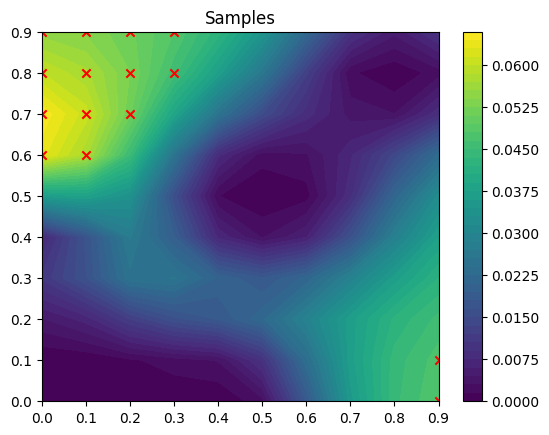

In [6]:
# Sampler (e.g., GFlowNet, or Random Sampler)
from sampler.sampler import GreedySampler, RandomSampler

sampler = GreedySampler(surrogate)
# sampler = RandomSampler(surrogate)
sampler.fit()
samples = sampler.get_samples(n_samples * 3, grid_flat.clone()).cpu()

# plot acq function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values, grid_flat.clone(), scatter_markers=samples
)
plt.title("Samples")
plt.show()

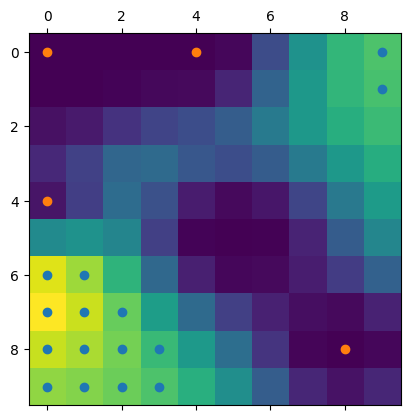

In [7]:
acq = surrogate.get_acquisition_values(grid_flat.clone()).detach().cpu()
plt.matshow(acq.reshape(int(len(acq) ** (1 / 2)), int(len(acq) ** (1 / 2))))
plt.scatter(samples.cpu()[:, 1] * grid_size, samples.cpu()[:, 0] * grid_size)
plt.scatter(baseline_states[:, 1].cpu(), baseline_states[:, 0].cpu())

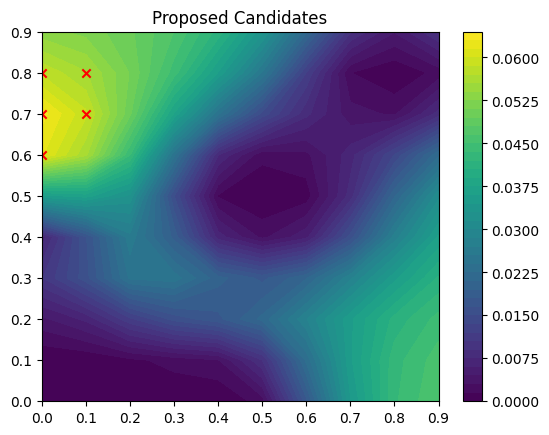

In [8]:
from filter.filter import Filter, OracleFilter

filter = Filter()
# filter = OracleFilter(oracle)
filtered_samples = filter(n_samples, samples)

# plot oracle function with proposed candidates
fig, ax = plot_function(
    surrogate.get_acquisition_values,
    grid_flat.clone(),
    scatter_markers=filtered_samples.to("cpu"),
)
plt.title("Proposed Candidates")
plt.show()

In [28]:
from importlib import reload  # Python 3.4+
import surrogate.surrogate as surrogate

reload(surrogate)

from surrogate.surrogate import SingleTaskGPRegressor

surrogate = SingleTaskGPRegressor(device="cpu", float_precision=float_prec, maximize=False)
train_data, test_data = dataset_handler.get_dataloader()
surrogate.fit(train_data)

In [29]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")


In [30]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger/wandb.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

logger = hydra.utils.instantiate(config_logger.logger, config_logger, _recursive_=False)

{'logger': {'_target_': 'gflownet.utils.logger.Logger', 'do': {'online': False, 'times': False}, 'project_name': 'GFlowNet', 'train': {'period': 1}, 'test': {'first_it': True, 'period': 100, 'n': 100, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}, 'n_top_k': 5000, 'top_k': 100, 'top_k_period': -1, 'n_trajs_logprobs': 10, 'logprobs_batch_size': 100, 'logprobs_bootstrap_size': 10000, 'max_data_logprobs': 100000.0}, 'oracle': {'period': 100000, 'k': [1, 10, 100]}, 'checkpoints': {'period': 1000}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'overwrite': True}, 'debug': False, 'lightweight': False, 'progress': True, 'context': '0', 'notes': None, 'tags': ['gflownet']}}


In [31]:
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger/wandb.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

# Logger
# from utils.logger import Logger

# logger = Logger(config=OmegaConf.create(), **config_logger)
logger = hydra.utils.instantiate(config_logger.logger, config_logger, _recursive_=False)

with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_sampler = compose(config_name="sampler/gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(config_sampler))
    print(config_sampler)

grid_env = hydra.utils.instantiate(
    config_sampler.sampler.env,
    proxy=surrogate,
    device="cpu",
    float_precision=float_prec,
)

# The policy is used to model the probability of a forward/backward action
forward_policy = hydra.utils.instantiate(
    config_sampler.sampler.policy.forward,
    env=grid_env,
    device="cpu",
    float_precision=float_prec,
)
backward_policy = hydra.utils.instantiate(
    config_sampler.sampler.policy.backward,
    env=grid_env,
    device="cpu",
    float_precision=float_prec,
)

# State flow
if config_sampler.sampler.state_flow is not None:
    state_flow = hydra.utils.instantiate(
        config_sampler.sampler.state_flow,
        env=grid_env,
        device="cpu",
        float_precision=float_prec,
        base=forward_policy,
    )
else:
    state_flow = None

# GFlowNet Agent
sampler = hydra.utils.instantiate(
    config_sampler.sampler.agent,
    device="cpu",
    float_precision=float_prec,
    env=grid_env,
    forward_policy=forward_policy,
    backward_policy=backward_policy,
    state_flow=state_flow,
    buffer=config_sampler.sampler.env.buffer,
    logger=logger,
)

{'logger': {'_target_': 'gflownet.utils.logger.Logger', 'do': {'online': False, 'times': False}, 'project_name': 'GFlowNet', 'train': {'period': 1}, 'test': {'first_it': True, 'period': 100, 'n': 100, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}, 'n_top_k': 5000, 'top_k': 100, 'top_k_period': -1, 'n_trajs_logprobs': 10, 'logprobs_batch_size': 100, 'logprobs_bootstrap_size': 10000, 'max_data_logprobs': 100000.0}, 'oracle': {'period': 100000, 'k': [1, 10, 100]}, 'checkpoints': {'period': 1000}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'overwrite': True}, 'debug': False, 'lightweight': False, 'progress': True, 'context': '0', 'notes': None, 'tags': ['gflownet']}}
{'sampler': {'env': {'defaults': ['base'], '_target_': 'gflownet.envs.grid.Grid', 'id': 'grid', 'func': 'corners', 'n_dim': 2, 'length': 3, 'max_increment': 1, 'max_dim_per_action': 1, 'cell_min': -1, 'cell_max': 1, 'buffer': {'data_path': None, 'train': None, 'test': {'type': 'all', 'output_csv': 'grid_test.csv', 'outpu

In [32]:
sampler.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...



  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 must have the same dtype

In [ ]:

# Logger
# from utils.logger import Logger

# logger = Logger(config=OmegaConf.create(), **config_logger)

In [ ]:
from gflownet.envs.grid import Grid as GFlowNetGridEnv

grid_env = GFlowNetGridEnv(
    n_dim=2,
    length=grid_size,
    max_increment=1,
    max_dim_per_action=1,
    cell_min=0,
    cell_max=1,
    proxy=surrogate,
    reward_func="identity",
)

In [28]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
import hydra
from omegaconf import OmegaConf

abs_config_dir = os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_gflownet = compose(config_name="gflownet.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_gflownet)

# GFlowNetAgent
from gflownet.policy.base import Policy
from gflownet.gflownet import GFlowNetAgent

forward_policy = Policy(
    config_gflownet.policy.forward,
    env=grid_env,
    device=device,
    float_precision=torch.double,
)

backward_policy = Policy(
    config_gflownet.policy.backward,
    env=grid_env,
    device=device,
    float_precision=torch.double,
)

sampler = GFlowNetAgent(
    grid_env,
    device=device,
    float_precision=torch.double,
    forward_policy=forward_policy,
    backward_policy=backward_policy,
    logger=logger,
    **config_gflownet
)

{'seed': 0, 'optimizer': {'z_dim': 16, 'loss': 'trajectorybalance', 'lr': 0.0001, 'lr_decay_period': 1000000, 'lr_decay_gamma': 0.5, 'lr_z_mult': 100, 'method': 'adam', 'early_stopping': 0.0, 'ema_alpha': 0.5, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'sgd_momentum': 0.9, 'batch_size': {'forward': 10, 'backward_dataset': 0, 'backward_replay': 0}, 'train_to_sample_ratio': 1, 'n_train_steps': 5000, 'bootstrap_tau': 0.0, 'clip_grad_norm': 0.0}, 'state_flow': None, 'batch_reward': True, 'mask_invalid_actions': True, 'temperature_logits': 1.0, 'random_action_prob': 0.0, 'pct_offline': 0.0, 'replay_capacity': 0, 'replay_sampling': 'permutation', 'train_sampling': 'permutation', 'num_empirical_loss': 200000, 'oracle': {'n': 500}, 'sample_only': False, 'active_learning': False, 'buffer': {'train': {'path': None, 'n': None, 'type': None, 'seed': None, 'output_csv': None}, 'test': {'path': None, 'type': 'all', 'output_pkl': 'buffer_data_test.csv', 'n': None, 'seed': None, 'output_csv': None}}, 'po

In [29]:
sampler.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

Compute logprobs...
Sampling backward actions from test data to estimate logprobs...



  0%|          | 0/5000 [00:03<?, ?it/s]


RuntimeError: index_add_(): self (Double) and source (Float) must have the same scalar type

In [115]:
from gflownet.utils.batch import Batch
batch = Batch(env=grid_env, device=device, float_type=float_prec)

In [116]:
# Make indices of batch consecutive since they are used for indexing here
# Get necessary tensors from batch
states_policy = batch.get_states(policy=True)
states = batch.get_states(policy=False)
actions = batch.get_actions()
parents_policy = batch.get_parents(policy=True)
parents = batch.get_parents(policy=False)
traj_indices = batch.get_trajectory_indices(consecutive=True)
# Forward trajectories
masks_f = batch.get_masks_forward(of_parents=True)
policy_output_f = forward_policy(parents_policy)

IndexError: list index out of range

In [11]:
# # environment
# import config
# train = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# test = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# buffer = config.env.Buffer(train=train, test=test)
# config_env = config.env.Grid_Env(
#     buffer,
#     min_step_len=1,
#     max_step_len=1,
#     cell_min=-1,
#     cell_max=1
# )

# from environment.grid_env import GridEnv
# env = GridEnv(**config_env.__dict__)